# Validate FC with field data

1. Find field data; this field data is the Star transects from [the JRSRP geoserver wfs service](https://field-geoserver.jrsrp.com/geoserver/aus/wfs?service=wfs&version=1.1.0&request=GetFeature&typeNames=aus:star_transects&outputFormat=csv) which can be visualised through [the TERN Landscapes-JRSRP Field Data Portal](https://field.jrsrp.com/) and is available as a csv
2. Load corresponding surface reflectance from datacube or pickle;
3. Calculate FC and compare to field data.

In [1]:
# define sensor_name
#sensor_name = 'Landsat 8 noscaling'
#sensor_name = 'Landsat 8 current'
sensor_name = 'Landsat 8'
#sensor_name = 'Landsat 7'
#sensor_name = 'Sentinel 2A'
#sensor_name = 'Sentinel 2B'

## Load modules

In [2]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')
import datacube
from fc.fractional_cover import compute_fractions
import sys

sys.path.append("../Scripts")
from dea_datahandling import load_ard

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from matplotlib import gridspec 
from shapely import wkt

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


## Function to compute the fractional covers as viewed by the satellite for the site
## Required a site properties object

In [3]:
# Function to compute the fractional covers as viewed by the satellite for the site
# Required a site properties object

def fractionalCoverSatView(siteProperties):
    '''equations to calculate fractional cover from the csv data'''
    nTotal = siteProperties['num_points']
    
    # Canopy Layer
    nCanopyBranch = siteProperties['over_b'] * nTotal / 100.0
    nCanopyDead = siteProperties['over_d'] * nTotal / 100.0
    nCanopyGreen = siteProperties['over_g'] * nTotal / 100.0
    
    # Midstory Layer
    nMidBranch = siteProperties['mid_b'] * nTotal / 100.0
    nMidGreen = siteProperties['mid_g'] * nTotal / 100.0
    nMidDead = siteProperties['mid_d'] * nTotal / 100.0
    
    # Ground Layer
    nGroundDeadLitter = (siteProperties['dead'] + siteProperties['litter']) * nTotal / 100.0
    nGroundCrustDistRock = (siteProperties['crust'] + siteProperties['dist'] + siteProperties['rock']) * nTotal / 100.0
    nGroundGreen = siteProperties['green'] * nTotal / 100.0
    nGroundCrypto = siteProperties['crypto'] * nTotal / 100.0
    
    # Work out the canopy elements as viewed from above
    canopyFoliageProjectiveCover = nCanopyGreen / (nTotal - nCanopyBranch)
    canopyDeadProjectiveCover = nCanopyDead / (nTotal - nCanopyBranch)
    canopyBranchProjectiveCover = nCanopyBranch / nTotal * (1.0 - canopyFoliageProjectiveCover - canopyDeadProjectiveCover)
    canopyPlantProjectiveCover = (nCanopyGreen+nCanopyDead + nCanopyBranch) / nTotal
    
    # Work out the midstorey fractions
    midFoliageProjectiveCover = nMidGreen / nTotal
    midDeadProjectiveCover = nMidDead / nTotal
    midBranchProjectiveCover = nMidBranch / nTotal
    midPlantProjectiveCover = (nMidGreen + nMidDead + nMidBranch) / nTotal
    
    # Work out the midstorey  elements as viewed by the satellite using a gap fraction method
    satMidFoliageProjectiveCover = midFoliageProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidDeadProjectiveCover = midDeadProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidBranchProjectiveCover = midBranchProjectiveCover * (1 - canopyPlantProjectiveCover)
    satMidPlantProjectiveCover = midPlantProjectiveCover * (1 - canopyPlantProjectiveCover)
    
    # Work out the groundcover fractions as seen by the observer
    groundPVCover = nGroundGreen / nTotal
    groundNPVCover = nGroundDeadLitter / nTotal
    groundBareCover = nGroundCrustDistRock / nTotal
    groundCryptoCover = nGroundCrypto / nTotal
    groundTotalCover = (nGroundGreen + nGroundDeadLitter + nGroundCrustDistRock) / nTotal
    
    # Work out the ground cover proportions as seen by the satellite
    satGroundPVCover = groundPVCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundNPVCover = groundNPVCover * ( 1- midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundBareCover = groundBareCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundCryptoCover = groundCryptoCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    satGroundTotalCover = groundTotalCover * (1 - midPlantProjectiveCover) * (1 - canopyPlantProjectiveCover)
    
    # Final total covers calculated using gap probabilities through all layers
    totalPVCover = canopyFoliageProjectiveCover + satMidFoliageProjectiveCover + satGroundPVCover
    totalNPVCover = canopyDeadProjectiveCover + canopyBranchProjectiveCover + satMidDeadProjectiveCover + satMidBranchProjectiveCover + satGroundNPVCover
    totalBareCover = satGroundBareCover
    totalCryptoCover = satGroundCryptoCover
    
    return np.array([totalPVCover,totalNPVCover+totalCryptoCover,totalBareCover])

## Coefficients for FC computation
These are the `Landsat 8 Fudge Factor` used to make the spectrally different sensor on Landsat 8 perform similarly to Landsats 5 and 7 in the Fractional Cover algorithm. These are incorporated in to the Collection 3 config as `regression_coefficients` in [C3 product definition yaml](https://github.com/opendatacube/datacube-alchemist/blob/C3_Processing/examples/c3_config_fc.yaml)

In [4]:
# coefficients for FC compute

#these were used in collection 2 but are not correct as don't multiply by 10000/ 1e4
ls8_coefficients_current = {'blue': [0.00041, 0.9747], 'green': [0.00289, 0.99779], 'red': [0.00274, 1.00446], 
                       'nir': [4e-05, 0.98906], 'swir1': [0.00256, 0.99467], 'swir2': [-0.00327, 1.02551]}

#use these ones, they are correct (need to multiply by 10000 as the algorithm expects 0-10000 not 0-1)
ls8_coefficients = {'blue': [0.00041*1e4, 0.9747], 'green': [0.00289*1e4, 0.99779], 'red': [0.00274*1e4, 1.00446], 
                       'nir': [4e-05*1e4, 0.98906], 'swir1': [0.00256*1e4, 0.99467], 'swir2': [-0.00327*1e4, 1.02551]}

s2_coefficients = {'blue':[-0.0022*1e4, 0.9551],
                   'green':[0.0031*1e4, 1.0582],
                   'red':[0.0064*1e4, 0.9871],
                   'nir':[0.012*1e4, 1.0187],
                   'swir1':[0.0079*1e4, 0.9528],
                   'swir2':[-0.0042*1e4, 0.9688]}

# compute FC 
def compute_fc(input_ds, regression_coefficients):
    '''takes input dataset and multiplies by regression coefficients to compute fractional cover.
    returns an xarray DataArray with pv,npv,bs,ue bands'''
    
    input_data = input_ds.to_array().data
    is_valid_array= (input_data >0).all(axis=0)
    # Set nodata to 0                                                       
    input_data[:, ~is_valid_array] = 0
    # compute fractional_cover
    output_data = compute_fractions(input_data, regression_coefficients)
    output_data[:, ~is_valid_array] = -1
    return xr.DataArray(output_data, dims=('band','y','x'),
                        coords={'x':input_ds.x, 'y':input_ds.y, 'band':['pv', 'npv', 'bs', 'ue']})

In [5]:
# select good pixels using pixel quality
def ls_good(pq):
    return masking.make_mask(pq, cloud_acca = "no_cloud", cloud_fmask = "no_cloud",
                             cloud_shadow_acca = "no_cloud_shadow",
                             cloud_shadow_fmask = "no_cloud_shadow",
                             contiguous = True)
def s2_good(pq):
    return pq == 1

## Set up the query for each sensor 

In [6]:
# spectral bands used for fractional cover calculation

#this is correct for collection3  
ls_bands = ['nbart_green','nbart_red','nbart_nir','nbart_swir_1','nbart_swir_2']

#this is correct for collection 3
s2_bands = ['nbart_green','nbart_red','nbart_nir_1','nbart_swir_2','nbart_swir_3']

# sensor specific configurations - note no Landsat 5 as doesn't overlap with site surveys

sensor_config = {'Landsat 7':{'startdate':'1999-05-01', #updated for collection3
                              'product':'ga_ls7e_ard_3', 
                              'bands':ls_bands,
                              'resolution':(-30,30), 
                              'fc_coefficients': None}, 
                 
                 'Landsat 8 noscaling':{'startdate':'2013-03-01',
                                        'product':'ga_ls8c_ard_3', 
                                        'bands':ls_bands,
                                        'resolution':(-30,30), 
                                        'fc_coefficients': None}, 
                 
                 'Landsat 8':{'startdate':'2013-03-01', 
                              'product':'ga_ls8c_ard_3', 
                              'bands':ls_bands,
                              'resolution':(-30,30), 
                              'fc_coefficients':ls8_coefficients}, 
                 
                 'Landsat 8 current':{'startdate':'2013-03-01', 
                                      'product':'ga_ls8c_ard_3', 
                                      'bands':ls_bands,
                                      'resolution':(-30,30), 
                                      'fc_coefficients':ls8_coefficients_current}, 
                 
                 'Sentinel 2A':{'startdate':'2015-07-01', 
                                'product':'s2a_ard_granule', 
                                'bands':s2_bands,
                                'resolution':(-10,10), 
                                'fc_coefficients':s2_coefficients},
                 
                'Sentinel 2B':{'startdate':'2017-06-01', 
                               'product':'s2b_ard_granule', 
                               'bands':s2_bands,
                               'resolution':(-10,10), 
                               'fc_coefficients':s2_coefficients}
                }

### Load field data in from csv

In [7]:
# Load star_transects field data 
field = pd.read_csv('star_transects.csv')
field['geometry'] = field.geom.apply(wkt.loads)
field = gpd.GeoDataFrame(field)

#field data comes in in WGS84
field.crs = {'init': 'EPSG:4326'}

#transform to Australian Albers Equal Area 
field = field.to_crs({'init':'EPSG:3577'})

In [8]:
# Filter data by date - get dates later than the first observation of the satellite
field = field.loc[field['obs_time'] > sensor_config[sensor_name]['startdate']]

### Calculate field measured fractions

In [9]:
# Calculate field measured fractions
field = field.merge(
    field.apply(fractionalCoverSatView, axis=1, result_type= 'expand').rename(
        columns = {0:'total_pv',1:'total_npv',2:'total_bs'}),
    left_index=True, right_index=True)
field = field[field.apply(lambda x: x['total_pv']+x['total_npv']+x['total_bs'], axis=1) >0.95]

### Match to albers tiles to check distribution

In [10]:
# Match to albers tiles to check distribution
albers_tiles = gpd.read_file('Albers_Australia_Coast_and_Islands.shp')
albers_tiles.crs = {'init':'EPSG:3577'}
matched = gpd.sjoin(field, albers_tiles, how='inner', op = 'intersects')
field_tiles = albers_tiles.merge(matched.groupby('label')['FID'].count().sort_values(ascending=False).to_frame('count').reset_index()
    , on='label', how='right')
print("Total number of data points is",len(field))
print("Largest number of data points in a tile is", field_tiles.loc[field_tiles['count'].idxmax()]['count'])

Total number of data points is 2236
Largest number of data points in a tile is 70


### Visual check of field data distribution

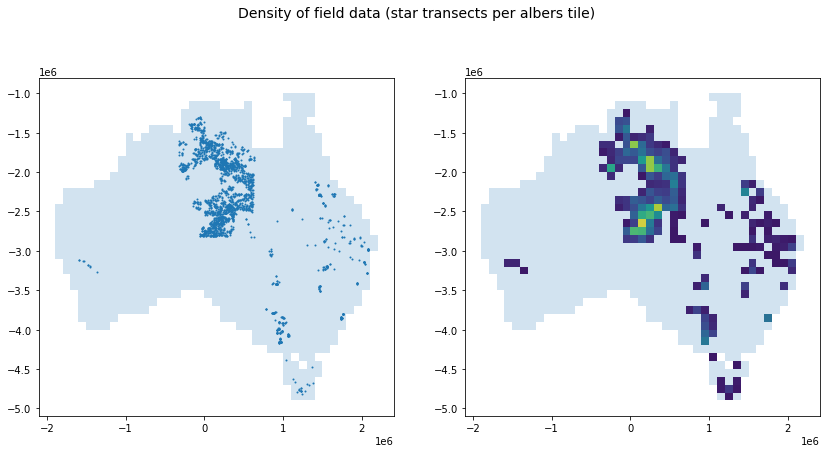

In [11]:
# Visual check of field data distribution
f, axes = plt.subplots(1, 2, figsize=(14,7))
plt.suptitle('Density of field data (star transects per albers tile)', size =14)
ax0 = field.plot(markersize=1, ax=axes[0])
albers_tiles.plot(alpha=0.2, ax = ax0)

ax1 =field_tiles.plot(column='count', cmap = 'viridis', ax=axes[1])
albers_tiles.plot(alpha=0.2, ax = ax1)
None

In [12]:
# load data from cube
dc = datacube.Datacube()

### find temporally and spatially aligned EO data 

In [13]:
# #test data
# row = field.iloc[-1]
# sensor_name = 'Landsat 8'
# plot_rad = 50
# window_days = 60 #window_days = 15
# #sensor_config = sensor_config[sensor_name]
# sensor_config =sensor_config['Landsat 8']

In [15]:
#nTotal = siteProperties['num_points']

### calculate fractional cover

In [16]:
# calculate fractional cover
def fractionalCover(row, sensor_config = sensor_config[sensor_name], plot_rad = 50, window_days = 15):
    '''this finds data within 15 days of an observation and 50 ??? of an observation
    #FIXME check nodata defaults here to -1, I think we need to replace with 255 '''

    # nodata default to return in case no data matches the chosen window around the field observation
    fc_dict = {'fc_time': '', 'pv': -1, 'npv': -1, 'bs': -1, 'pv_std': -1, 'npv_std': -1, 'bs_std': -1 }

    # define search - grab near observations in space and time
    x = row.geometry.x - plot_rad, row.geometry.x + plot_rad
    y = row.geometry.y - plot_rad, row.geometry.y + plot_rad
    time = (str(np.datetime64(row.obs_time) - np.timedelta64(window_days,'D')),
            str(np.datetime64(row.obs_time) + np.timedelta64(window_days,'D'))
           )

    #use a reusable query dictionary
    query = {'measurements':sensor_config['bands'],
             'group_by':'solar_day',
             'x' : x, 
             'y' : y,  
             'time' : time, 
             'crs' : 'EPSG:3577', #this defines the crs of the input query
             'resolution' : sensor_config['resolution'],
             'output_crs' : 'EPSG:3577'}          

    try: 
        #need to test if load_ard will return data here, as the alternative is that the data is not returned
        nbart = load_ard(dc,
            products = [sensor_config['product']], #need square brackets to deliver as a list
            min_gooddata=1, #need all valid pixels for the comparison
            fmask_categories=['valid'], #don't want snow or water in fractional cover comparison
            mask_pixel_quality=True, #this could give us some issues with dtype later on
            mask_contiguity='nbart_contiguity',
            ls7_slc_off=True,
            **query); #suppress output for this function to save printing space
        
    except ValueError:
        print(f"No data found at {x},{y},{time}")
        return fc_dict
    
    # If there aren't any results, this function will return nodata values.
    if len(nbart.time) == 0: return fc_dict

    ### choose the closest clear timestep to keep

    # only keep closest time
    nbart = nbart.isel(time=[np.abs(nbart.time-np.datetime64(row.obs_time)).argmin()])

    # compute FC
    fc = nbart.groupby('time').apply(compute_fc,
                                     regression_coefficients = sensor_config['fc_coefficients'],
                                    ).to_dataset(dim='band')

    ## Not sure why groupby was needed here?
    #fc_mean = fc.where(fc>=0).groupby('time').mean()
    # fc_std = fc.where(fc>=0).groupby('time').std()
        # take average
    fc_mean = fc.where(fc>=0).groupby('time').mean(dim=['x','y'])
    fc_std = fc.where(fc>=0).groupby('time').std(dim=['x','y'])

    fc_dict['fc_time'] = fc.time.values[0].astype(str)
    for var_name in fc_mean.data_vars:
        fc_dict[var_name.lower()] = fc_mean[var_name].values[0]
        fc_dict[var_name.lower()+'_std'] = fc_std[var_name].values[0]
        
    return fc_dict

### Compute Fractional Cover

In [17]:
%%time
# If there aren't any results, this function will return nodata values.
fractions = field.apply(fractionalCover, axis=1, result_type = 'expand')
field = field.merge(fractions, how = 'inner', left_index=True, right_index=True)
field = field[field['pv']>=0]

Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 2 out of 4 time steps with at least 100.0% good quality pixels
Applying pixel quality/cloud mask
Applying contiguity mask
Loading 2 time steps
Finding datasets
    ga_ls8c_ard_3
No data found at (-1536454.6901499259, -1536354.6901499259),(-3127686.452573563, -3127586.452573563),('2014-06-10', '2014-07-10')
Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 4 out of 4 time steps with at least 100.0% good quality pixels
Applying pixel quality/cloud mask
Applying contiguity mask
Loading 4 time steps
Finding datasets
    ga_ls8c_ard_3
No data found at (-1453278.261888452, -1453178.261888452),(-3199523.589279422, -3199423.589279422),('2014-06-09', '2014-07-09')
Finding datasets
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 1 out of 2 time steps with at least 100.0% good quality pixels
Applying pixel quality/cloud mask
A

In [18]:
field.to_file('field_with_fc_%s.shp'%''.join(sensor_name.split()))

In [19]:
field = gpd.read_file('field_with_fc_%s.shp'%''.join(sensor_name.split()))

# of validation points: 2043
Band:BS, slope=1.0097239517721466, r2=0.5946726156908451
Correlations: 0.843207076384315 0.8522250433635823 0.6598048821399727
RMSE: 13.981907513062845
Band:PV, slope=0.8925171656086555, r2=0.6280108849379854
Correlations: 0.837311738006529 0.7749505271139527 0.5860486128878867
RMSE: 8.642981839983795
Band:NPV, slope=0.8291621856230266, r2=0.4950247010812362
Correlations: 0.765712944222817 0.7759088519636863 0.5843997677839449
RMSE: 16.94538457386949


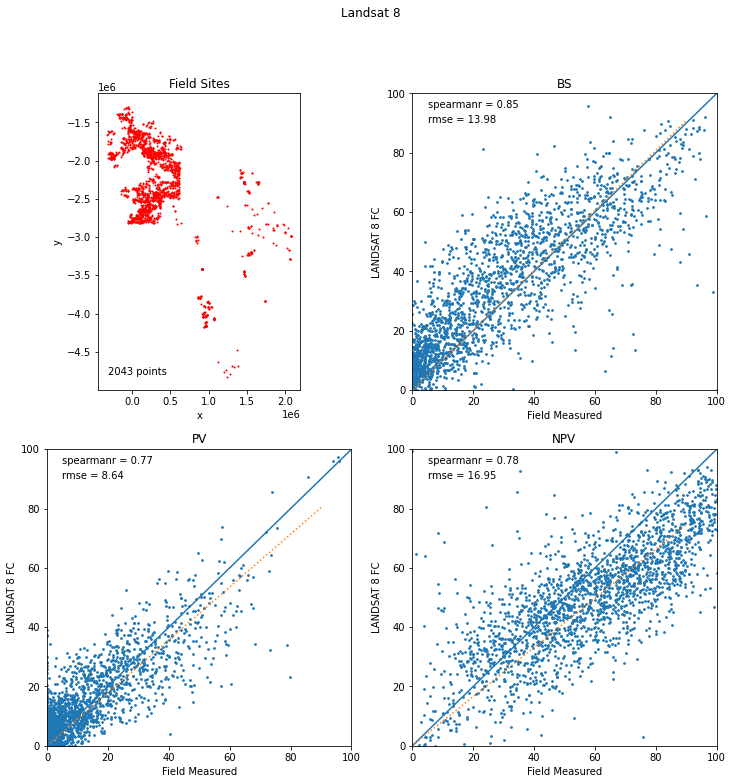

In [20]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

def validate(field_all, title=None):
    field = field_all[(field_all[['pv','npv','bs']]>=0.).all(axis=1)]
    field = field[(field[['pv_std','npv_std','bs_std']]<=10.).all(axis=1)]
    field = field[field['ue'] <25]
    print("# of validation points:", len(field))
    
    regr = linear_model.LinearRegression(fit_intercept=False)    

    f = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(2,2)

    xedges=yedges=list(np.arange(0,102,2))
    X, Y = np.meshgrid(xedges, yedges)
    cmname='YlGnBu'
    if title: plt.suptitle(title)
    
    ax1 = plt.subplot(gs[0])
    field.plot(markersize=1, ax= ax1, color='r')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title('Field Sites')
    ax1.text(0.05, 0.05, "%d points"%len(field), transform=ax1.transAxes)
    
    rmses = []
    for band_id, band in enumerate(['BS','PV','NPV']):
        arr1 = field['total_%s'%band.lower()].values.ravel()*100.
        arr2 = field[band.lower()].values.ravel()
        regr.fit(arr1[:,np.newaxis], arr2[:,np.newaxis])
        
        print('Band:{0}, slope={1}, r2={2}'.format(band, regr.coef_[0][0],
                                                regr.score(arr1[:,np.newaxis], arr2[:,np.newaxis])))
        sr = spearmanr(arr1, arr2)[0]
        print('Correlations:', pearsonr(arr1, arr2)[0], sr, kendalltau(arr1, arr2)[0])
        rmse = np.sqrt(mean_squared_error(arr1, arr2))
        print('RMSE:',rmse)
        rmses.append(rmse)

        ax1 = plt.subplot(gs[band_id+1])
        ax1.scatter(arr1, arr2, s=3)
        ax1.set_title(band)
        
        ax1.plot([0,100],[0,100])
        ax1.plot(np.arange(0,100,10), regr.predict(np.arange(0,100,10)[:,np.newaxis]), ':')
        ax1.text(5, 95, 'spearmanr = {0:.2f}'.format(sr))
        ax1.text(5, 90, 'rmse = {0:.2f}'.format(rmse))
        ax1.set_xlabel('Field Measured')
        ax1.set_ylabel('%s FC'%sensor_name.upper())
        ax1.set_xlim((0,100))
        ax1.set_ylim((0,100))
    
    f.savefig('validate_fc_%s.png'%''.join(sensor_name.split()))


validate(field, title=sensor_name)
